## Initial Local Creation of Bayesian Network

## HC + Bdeu

The experimentation and testing of the initial simple Bayesian Network on a smaller dataset for testing

In [1]:
import pgmpy
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt
import sys
sys.path.insert(0,"..")
from Data.DataPreprocessing import DataPreprocessing as myData
from pgmpy import estimators
from pgmpy.inference import VariableElimination
from sklearn.metrics import f1_score, accuracy_score, roc_curve, precision_score, recall_score, roc_auc_score, balanced_accuracy_score
from pgmpy.metrics import correlation_score, log_likelihood_score, structure_score


INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
/home/zachs/miniconda3/envs/HonoursResearch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data importing and preprocessing

In [2]:
loaded_data = myData.load_data(num_rows = 1000)
#display(loaded_data)
data = myData.preprocess_data(loaded_data)
train_data, test_data = myData.split_data(data)

/home/zachs/miniconda3/envs/HonoursResearch/lib/python3.11/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (31). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/zachs/miniconda3/envs/HonoursResearch/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/zachs/miniconda3/envs/HonoursResearch/lib/python3.11/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (31) found smaller than n_clusters (50). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/zachs/miniconda3/envs/HonoursResearch/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are r

### Structure Learning

In [3]:
scoring_method = estimators.BDeuScore(data=train_data, equivalent_sample_size=10)  # TODO change sample size hyperparameter
est = estimators.HillClimbSearch(data=train_data, use_cache = True)
estimated_model = est.estimate(
    scoring_method=scoring_method, max_iter=int(1e2))
model = pgmpy.models.BayesianNetwork(estimated_model.edges())
model.add_nodes_from(estimated_model.nodes())
print(model.nodes())
print(model.edges())

100%|██████████| 100/100 [14:42<00:00,  8.82s/it]

['loan_amnt', 'funded_amnt_inv', 'funded_amnt', 'installment', 'term', 'total_rec_int', 'grade', 'int_rate', 'verification_status', 'sub_grade', 'home_ownership', 'tot_hi_cred_lim', 'avg_cur_bal', 'loan_status', 'out_prncp', 'collection_recovery_fee', 'last_pymnt_amnt', 'total_rec_prncp', 'last_credit_pull_d', 'last_fico_range_high', 'num_tl_30dpd', 'purpose', 'title', 'delinq_2yrs', 'num_tl_90g_dpd_24m', 'fico_range_high', 'fico_range_low', 'inq_last_6mths', 'inq_last_12m', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'recoveries', 'debt_settlement_flag', 'last_pymnt_d', 'last_fico_range_low', 'collections_12_mths_ex_med', 'delinq_amnt', 'application_type', 'tax_liens', 'open_il_12m', 'pub_rec_bankruptcies', 'inq_fi', 'pub_rec', 'initial_list_status', 'acc_now_delinq', 'open_acc_6m', 'mo_sin_rcnt_tl', 'open_rv_12m', 'open_il_24m', 'num_tl_op_past_12m', 'acc_open_past_24mths', 'total_bal_il', 'total_il_high_credit_limit', 'open_rv_24m', 'chargeoff_within_12_mths', 'mo_sin_old_rev

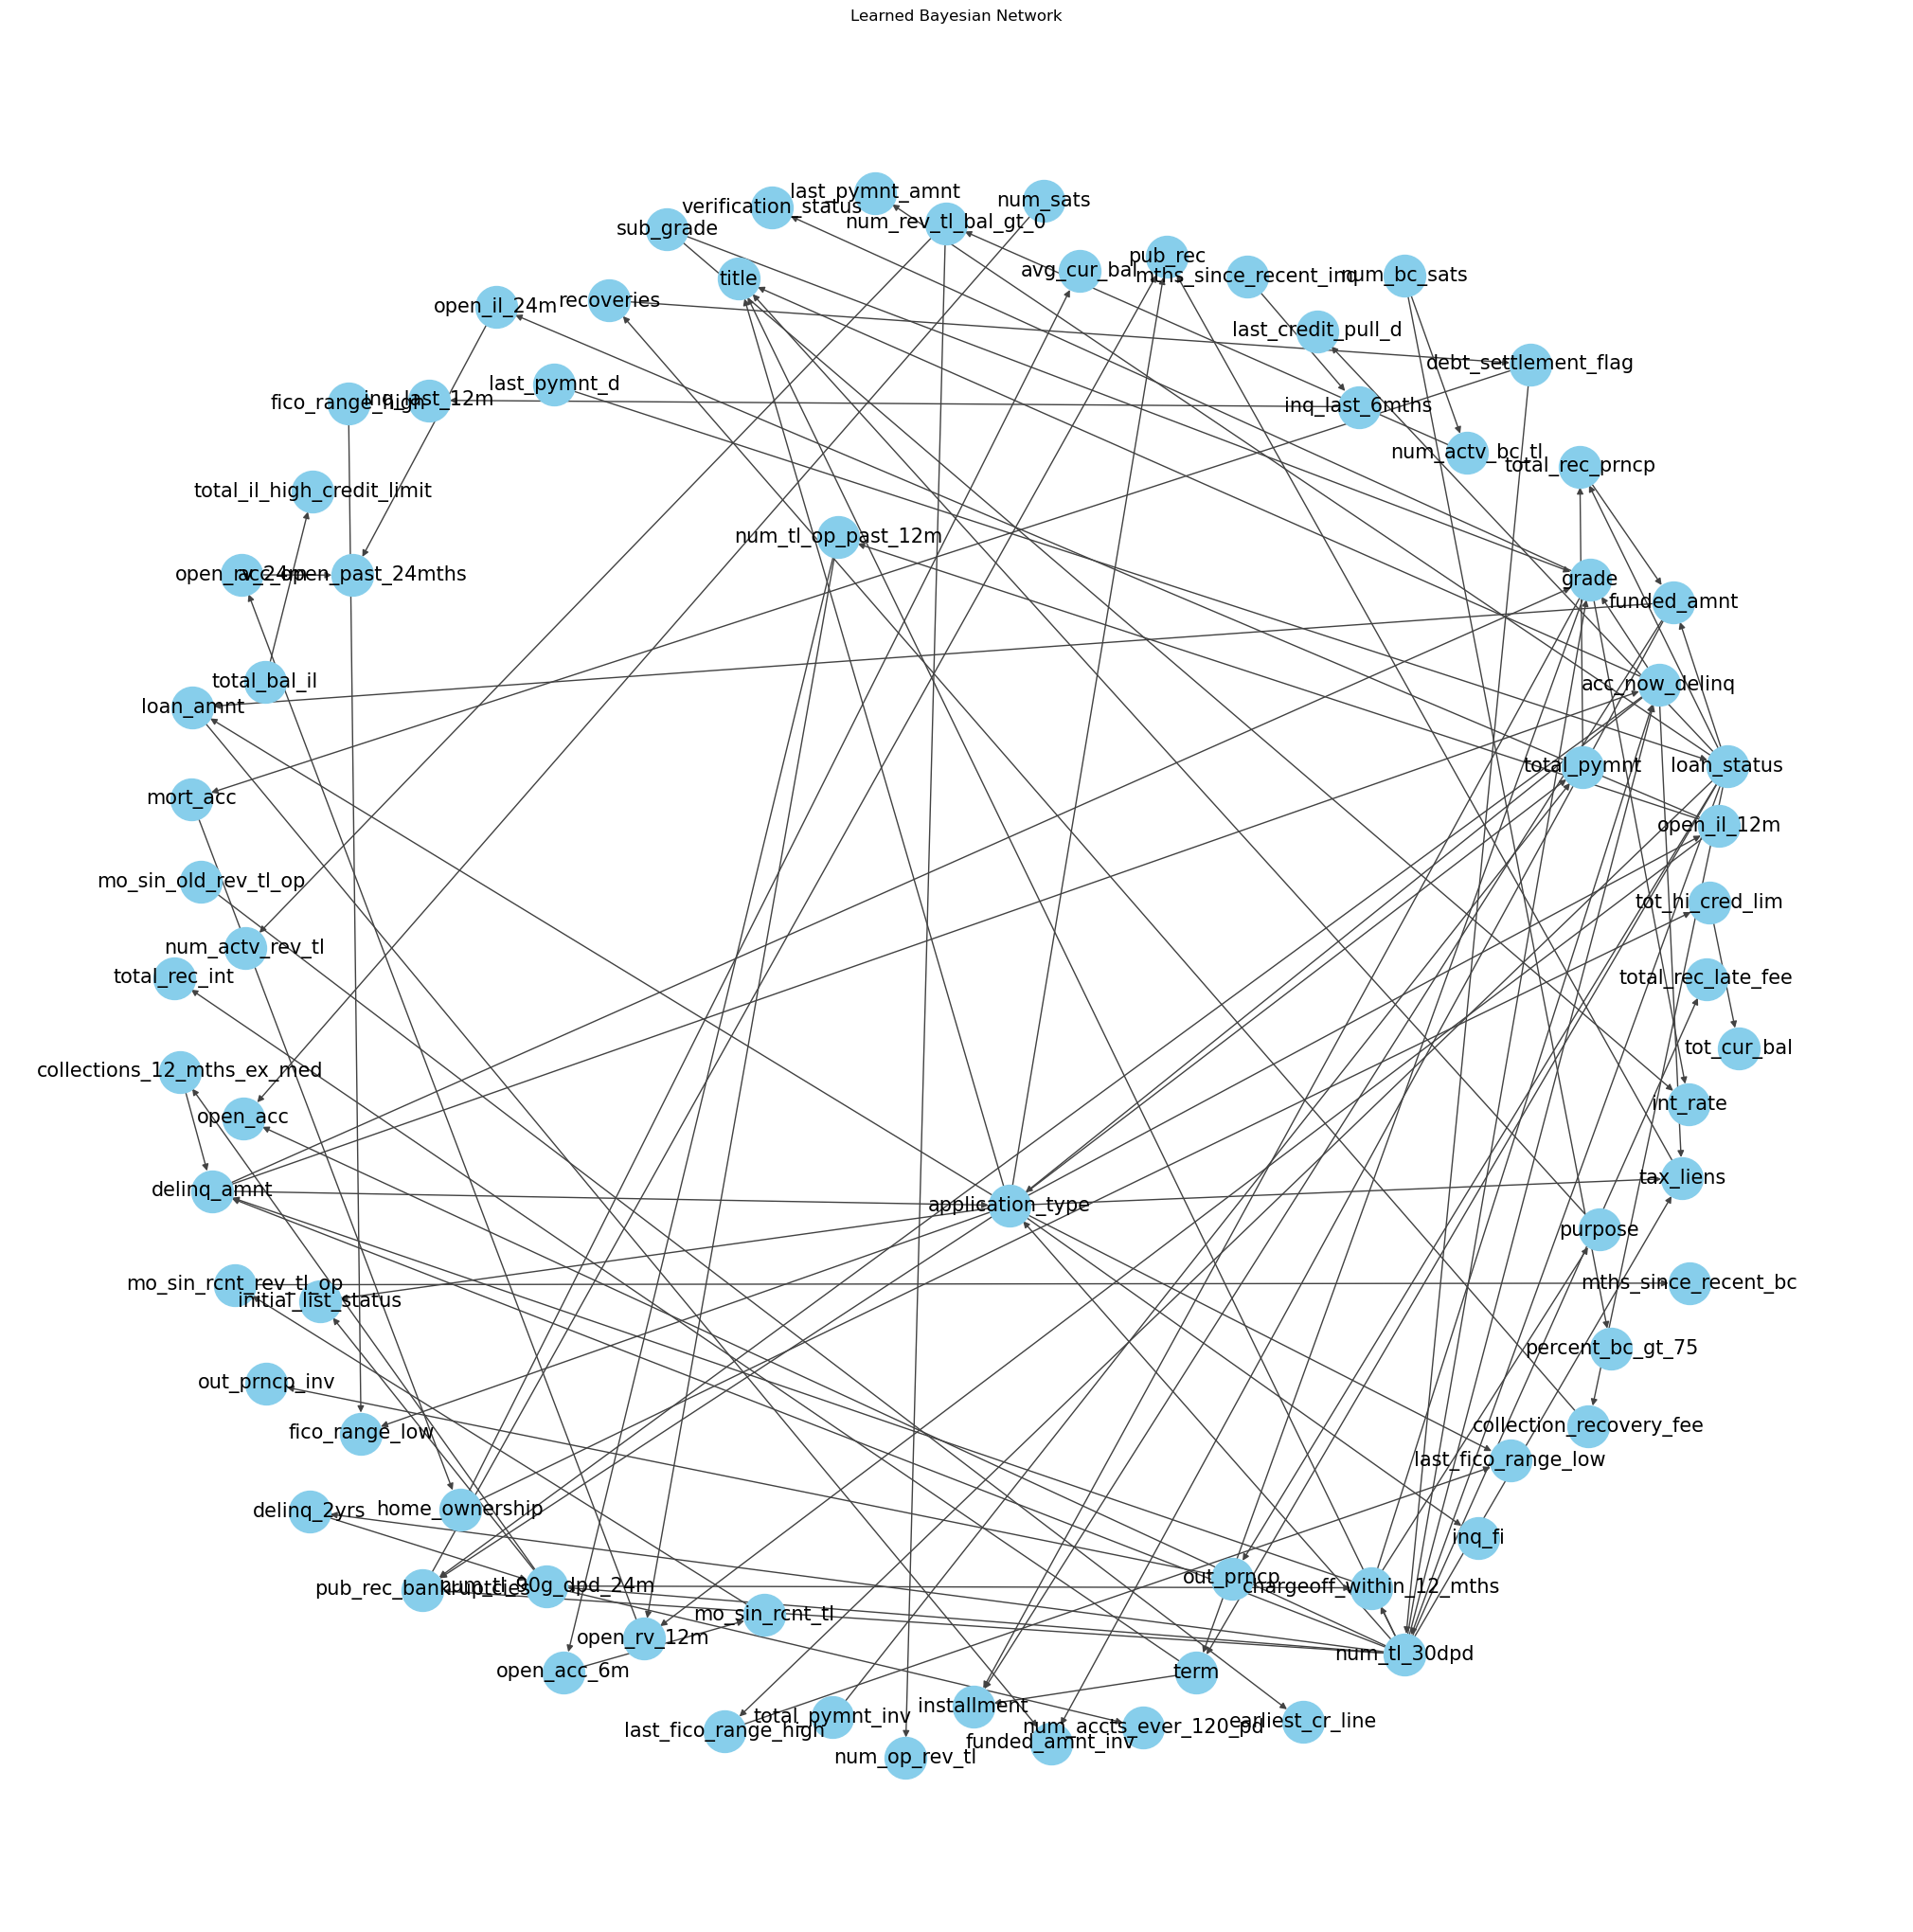

In [4]:
#active_trail_nodes = model.active_trail_nodes('loan_status')['loan_status']
#active_trail_nodes_list = list(active_trail_nodes)
#original_nodes = list(model.nodes())
#for node in original_nodes:
#    if node not in active_trail_nodes_list:
#        model.remove_node(node)
        

nx_graph = nx.DiGraph(model.edges())
pos = nx.spring_layout(nx_graph,2)
plt.figure(figsize=(20, 20))
nx.draw(nx_graph, pos, with_labels=True, node_size=1000, node_color = 'skyblue', edge_color='#424242',font_size=15,font_color='black')
plt.title('Learned Bayesian Network')
plt.show()

###  Parameter Estimation

In [5]:
parameter_estimator = estimators.BayesianEstimator(model,train_data)
parameters = parameter_estimator.get_parameters(n_jobs=6)

for i in range(len(parameters)):
    model.add_cpds(parameters[i])
    #print(parameters[i])

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.


### Inference

In [6]:
def performInference(target_label):
    y_pred = []
    y_true = []    
    testing_evidence_list = myData.get_evidence_list(test_data, target_label=target_label)
    inference = VariableElimination(model)
    for i in range(len(testing_evidence_list)):
        for attribute in list(testing_evidence_list[i].keys()):
            if attribute not in model.nodes():
                del testing_evidence_list[i][attribute]
                
    for i in range(len(testing_evidence_list)):
        loan_status = inference.map_query([target_label], evidence = testing_evidence_list[i], show_progress= True) 
        y_pred.append(loan_status[target_label])
        y_true.append(test_data[target_label].iloc[i])
    
    return y_pred, y_true
    
loan_status_y_pred, loan_status_y_true = performInference('loan_status')    


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

## Testing

In [ ]:
def testModel(y_true, y_pred):
    data_testing_corr_score = model.simulate(int(1e4))
    correlation_score_value = correlation_score(model, data_testing_corr_score, test="log_likelihood", significance_level=0.05)
    log_likelihood_score_value = log_likelihood_score(model, data_testing_corr_score)
    structure_score_value = structure_score(model, data_testing_corr_score, scoring_method="bic")
    print("correlation score: " + str(correlation_score_value))
    print("Log likelihood score: " + str(log_likelihood_score_value))
    print("Structure score: "+ str(structure_score_value))

    accuracy_score_value = accuracy_score(y_true, y_pred)
    f1score_value = f1_score(y_true, y_pred, average = None)
    precisionScore = precision_score(y_true, y_pred,average = None)
    recallScore = recall_score(y_true, y_pred,average = None)
    #roc_auc_score_value =  roc_auc_score(y_true, y_pred,average = None)
    balanced_accuracy_score_value = balanced_accuracy_score(y_true, y_pred, adjusted=True)

    f1_score_macro = f1_score(y_true, y_pred, average='macro')
    precision_score_macro = precision_score(y_true, y_pred, average='macro')
    recall_score_macro = recall_score(y_true, y_pred, average='macro')

    f1_score_weighted = f1_score(y_true, y_pred, average = 'weighted')
    precision_score_weighted = precision_score(y_true, y_pred, average = 'weighted')
    recall_score_weighted = recall_score(y_true, y_pred, average = 'weighted')

    print("accuracy score: "+str(accuracy_score_value))
    print("f1_score: "+str(f1score_value))
    print("precision score: "+str(precisionScore))
    print("recall score: "+str(recallScore))
    #print("roc auc score: "+str(roc_auc_score_value))
    print("balanced_accuracy_score: " + str(balanced_accuracy_score_value))
    print("\n\n")
    print("Macro scores:\n")
    print("recall_score_macro: "+str(recall_score_macro))
    print("f1_score_macro: "+str(f1_score_macro))
    print("precision_score_macro: "+str(precision_score_macro))
    print("\n")
    print("Weighted Scores:\n")
    print("recall_score_weighted: "+str(recall_score_weighted))
    print("f1_score_weighted: "+str(f1_score_weighted))
    print("precision_score_weighted: "+str(precision_score_weighted))
    
    
testModel(loan_status_y_true, loan_status_y_pred)